<a href="https://colab.research.google.com/github/Oreki820/Oreki820--Projeto-de-Parceria-EBAC-Semantix-Previsao-de-Atrasos-na-Entrega/blob/main/Projeto_semantix%2BEbac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🪐 Projeto de Parceria EBAC + Semantix  
## 📦 Previsão de Atrasos de Entrega — Base Olist (Kaggle)

Este projeto foi desenvolvido como parte da **parceria EBAC–Semantix**, com o objetivo de aplicar um **pipeline completo de Ciência de Dados** a um caso real de e-commerce e logística.  

O desafio consiste em **prever atrasos de entrega** de pedidos na base pública **Olist (Kaggle)**, utilizando técnicas avançadas de modelagem e validação de dados.  

---

### 🎯 Objetivos principais:
- Antecipar pedidos com risco de atraso;  
- Melhorar a precisão de prazos logísticos;  
- Reduzir custos e reclamações de clientes;  
- Criar um pipeline de dados replicável (Bronze → Silver → Gold).  

---

> 💡 *Motivação:*  
> Empresas como a **Semantix** utilizam fluxos de dados e aprendizado de máquina para gerar insights que impactam diretamente o negócio.  
> Este projeto simula exatamente esse tipo de fluxo.


# 📊 Entendendo a Base de Dados — Olist E-Commerce 🇧🇷

A base **Olist Brazilian E-Commerce (Kaggle)** contém informações detalhadas sobre transações reais de um marketplace brasileiro.  
Cada arquivo representa um aspecto diferente da operação de vendas.

| Arquivo | Descrição | Nível |
|:--|:--|:--|
| `olist_orders_dataset.csv` | Dados dos pedidos e prazos de entrega | Transacional |
| `olist_customers_dataset.csv` | Informações de clientes e estados | Identificação |
| `olist_products_dataset.csv` | Detalhes de produtos e categorias | Catálogo |
| `olist_order_payments_dataset.csv` | Tipos e valores de pagamento | Financeiro |
| `olist_order_items_dataset.csv` | Itens por pedido | Operacional |
| `product_category_name_translation.csv` | Tradução de categorias | Suporte |

---

> 🔎 *Nesta etapa, o ambiente será preparado para o download e extração dos arquivos da base pública da Olist (Kaggle), que servirá de ponto de partida para o pipeline Bronze → Silver → Gold.*


# **🧭 0 — Setup & Download (Kaggle → data/raw) (Bronze)**

Nesta etapa, preparei o ambiente para executar o projeto com segurança e reprodutibilidade.  
O objetivo é:

1. Instalar e atualizar bibliotecas necessárias;  
2. Configurar o acesso à conta do Kaggle;  
3. Baixar e extrair a base pública **Brazilian E-Commerce by Olist**;  
4. Criar a estrutura inicial de diretórios (`data/raw`, `data/silver`, `data/gold`, etc).  

> ⚙️ *Esta é a base do pipeline Bronze → Silver → Gold.*


In [1]:
import os, zipfile, subprocess
from pathlib import Path
!pip install -q great-expectations pyarrow seaborn
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from tqdm import tqdm
import great_expectations as ge
import json
!pip install -q great-expectations pyarrow seaborn tqdm

!pip install -q xgboost shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.6/813.6 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 35.1 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
# Atualizando e instalando dependências essenciais
!pip install -q kaggle great-expectations shap xgboost plotly duckdb polars geopandas pyarrow tqdm

# Criando estrutura básica de diretórios
!mkdir -p data/raw/olist data/silver data/gold notebooks src/etl src/features src/modeling expectations app

 🗂️ Estrutura de Diretórios Inicial

Após a execução, a seguinte estrutura será criada:

data/

┣ raw/

┃ ┗ olist/

┣ silver/

┣ gold/

┣ notebooks/

┣ src/

┃ ┣ etl/

┃ ┣ features/

┃ ┗ modeling/

┣ expectations/

┗ app/


> 📦 *Isso organiza o fluxo do projeto e segue o padrão profissional de Data Lakehouse.*

In [3]:
from google.colab import files
files.upload()  # fazendo upload do kaggle.json

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


 ⬇️ Download e Extração da Base Olist

Agora realizei o download automático da base **Brazilian E-Commerce by Olist** diretamente do Kaggle.  
O comando abaixo faz o download do arquivo `.zip` e o extrai em `data/raw/olist`.

> ✅ *Após essa célula, os dados estarão prontos para a camada Bronze (ingestão).*


In [4]:

BASE = Path(".")
RAW_DIR = BASE / "data" / "raw" / "olist"
RAW_DIR.mkdir(parents=True, exist_ok=True)

# Checar Kaggle CLI
!pip install -q kaggle
if not (Path.home()/".kaggle"/"kaggle.json").exists():
    print("⚠️ kaggle.json não encontrado. Execute o upload antes desta célula.")

# Download
!kaggle datasets download -d olistbr/brazilian-ecommerce -p data/raw/olist --force
# Extração
for z in RAW_DIR.glob("*.zip"):
    with zipfile.ZipFile(z, 'r') as f: f.extractall(RAW_DIR)
print("✅ Base Olist baixada e extraída em data/raw/olist")


Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
  0% 0.00/42.6M [00:00<?, ?B/s]
100% 42.6M/42.6M [00:00<00:00, 1.08GB/s]
✅ Base Olist baixada e extraída em data/raw/olist


---

# **📊 SEÇÃO 1 — EDA e Limpeza (Camada Silver)**

Nesta etapa, realizamos a **unificação, limpeza e validação** dos dados da Olist.  
O objetivo é criar uma tabela única e consistente (camada *Silver*) que servirá de base para os modelos de Machine Learning.

> 💡 *Camada Silver = dados limpos, integrados e validados, prontos para análise.*


In [5]:
# Diretórios base
RAW = Path("data/raw/olist")
SILVER = Path("data/silver")
SILVER.mkdir(parents=True, exist_ok=True)

print("📂 Diretório RAW:", RAW)
print("📂 Diretório SILVER:", SILVER)

📂 Diretório RAW: data/raw/olist
📂 Diretório SILVER: data/silver


### 🧱 Passo 1 — Carregamento das tabelas brutas (Camada Bronze → Silver)

Aqui li os arquivos originais da Olist (camada *raw/bronze*) e começei a preparação da camada Silver.  
Cada tabela representa um aspecto do negócio — pedidos, pagamentos, produtos e clientes.


In [6]:
def load_csv(name):
    path = RAW / name
    if not path.exists():
        print(f"⚠️ Arquivo não encontrado: {path.name}")
        return pd.DataFrame()
    return pd.read_csv(path)


print("📥 Carregando arquivos...")
orders = load_csv("olist_orders_dataset.csv")
items = load_csv("olist_order_items_dataset.csv")
payments = load_csv("olist_order_payments_dataset.csv")
customers = load_csv("olist_customers_dataset.csv")
products = load_csv("olist_products_dataset.csv")
cat_trans = load_csv("product_category_name_translation.csv")


📥 Carregando arquivos...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🕒 Passo 2 — Criação da variável `is_late`

Criei a flag `is_late` (1 = atraso, 0 = dentro do prazo), comparando a data de entrega real com a data prometida.  
Essa variável será minha **target principal** na modelagem supervisionada.

In [7]:
print("🕒 Convertendo colunas de data...")

date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]
for c in date_cols:
    orders[c] = pd.to_datetime(orders[c], errors="coerce")

orders["is_late"] = (
    (orders["order_delivered_customer_date"] > orders["order_estimated_delivery_date"])
    .fillna(False)
    .astype(int)
)

🕒 Convertendo colunas de data...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🔗 Passo 3 — Enriquecimento de produtos

Mesclei as tabelas de produtos e categorias traduzidas para obter um *dataset* mais informativo.  
Essa etapa me permite analisar atrasos por tipo de produto e categoria.


In [8]:
print("🔗 Mesclando tabelas de produtos e categorias...")

prod = products.merge(cat_trans, how="left", on="product_category_name")

items_prod = items.merge(prod, on="product_id", how="left")

# Função robusta para pegar a moda (corrige o erro IndexError)
def safe_mode(series):
    m = series.mode()
    return m.iloc[0] if not m.empty else np.nan


🔗 Mesclando tabelas de produtos e categorias...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 📊 Passo 4 — Agregação de itens e pagamentos por pedido

Agrupei os dados para cada pedido, somando valores e contabilizando itens.  
Também determinei o método principal de pagamento e número de parcelas.

In [9]:
print("📊 Agregando dados por pedido...")

agg_items = (
    items_prod.groupby("order_id")
    .agg(
        n_items=("order_item_id", "count"),
        total_price=("price", "sum"),
        freight=("freight_value", "sum"),
        main_category=("product_category_name_english", safe_mode),
    )
    .reset_index()
)

agg_pay = (
    payments.groupby("order_id")
    .agg(
        pay_value=("payment_value", "sum"),
        installments=("payment_installments", "max"),
        main_pay_type=("payment_type", safe_mode),
    )
    .reset_index()
)


📊 Agregando dados por pedido...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🧩 Passo 5 — Montagem da Camada Silver

Combinei pedidos, clientes, produtos e pagamentos em uma tabela unificada.  
Este é o coração da camada Silver, onde cada linha representa um pedido completo.

In [10]:
print("🧩 Montando camada Silver...")

silver = (
    orders.merge(customers, on="customer_id", how="left")
    .merge(agg_items, on="order_id", how="left")
    .merge(agg_pay, on="order_id", how="left")
)

🧩 Montando camada Silver...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🧹 Passo 6 — Limpeza e Salvamento

Removi duplicados e salvei os dados tratados em formato `.parquet`.  
O uso de Parquet otimiza espaço e velocidade, facilitando etapas futuras.

In [11]:
print("🧹 Limpando e salvando...")

silver.drop_duplicates(subset="order_id", inplace=True)
silver.to_parquet(SILVER / "orders_enriched.parquet", index=False)

print("✅ SILVER criada com sucesso!")
print(f"Total de registros: {len(silver):,}")
print(f"Colunas: {len(silver.columns)}")

🧹 Limpando e salvando...
✅ SILVER criada com sucesso!
Total de registros: 99,441
Colunas: 20


### 📈 Passo 7 — Análise Exploratória Inicial (EDA)

Gerei uma análise temporal simples mostrando o percentual de atrasos por mês.  
Essa visualização ajuda a entender tendências e sazonalidades do problema.

📈 Gerando EDA inicial...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


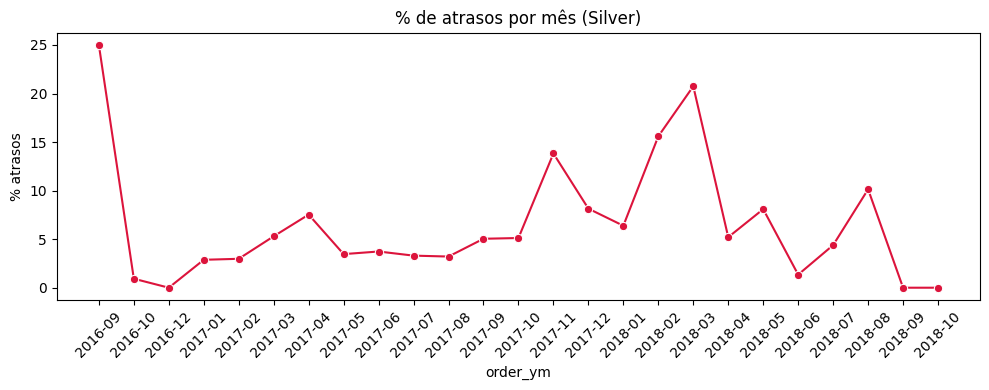

In [12]:
print("📈 Gerando EDA inicial...")

silver["order_purchase_timestamp"] = pd.to_datetime(
    silver["order_purchase_timestamp"], errors="coerce"
)
silver["order_ym"] = silver["order_purchase_timestamp"].dt.to_period("M").astype(str)

eda_time = (
    silver.groupby("order_ym")
    .agg(total=("order_id", "count"), late=("is_late", "sum"))
    .assign(pct_late=lambda d: 100 * d["late"] / d["total"])
    .reset_index()
)

plt.figure(figsize=(10, 4))
sns.lineplot(data=eda_time, x="order_ym", y="pct_late", color="crimson", marker="o")
plt.xticks(rotation=45)
plt.title("% de atrasos por mês (Silver)")
plt.ylabel("% atrasos")
plt.tight_layout()
plt.show()


### 🧠 Passo 8 — Validação de Qualidade de Dados (Great Expectations)

Nesta etapa, aplicquei verificações automáticas de consistência.  
Elas funcionam como “testes unitários” para dados, garantindo integridade antes da modelagem.

In [13]:
print("🧠 Validando estrutura básica (Data Quality Check)...")

def quality_check(df: pd.DataFrame):
    results = []

    def log(expectation: str, condition: bool):
        results.append({"expectation": expectation, "success": bool(condition)})

    # Checagens principais
    log("order_id not null", df["order_id"].notna().all())
    log("order_id unique", df["order_id"].is_unique)
    log("n_items >= 1", (df["n_items"] >= 1).all())
    log("pay_value >= 0", (df["pay_value"] >= 0).all())
    log("customer_id not null", df["customer_id"].notna().all())
    log("datas coerentes", (df["order_purchase_timestamp"] <= df["order_estimated_delivery_date"]).all())

    # Criar relatório
    results_df = pd.DataFrame(results)
    passed = results_df["success"].sum()
    total = len(results_df)

    print(f"✅ Expectativas validadas: {passed}/{total} passaram com sucesso")
    print(results_df)

    # Exportar resumo
    EXPECT_DIR = Path("expectations")
    EXPECT_DIR.mkdir(exist_ok=True)
    out_path = EXPECT_DIR / "silver_quality_report.txt"
    with open(out_path, "w", encoding="utf-8") as f:
        f.write("Data Quality Report — Silver Layer\n")
        for _, r in results_df.iterrows():
            f.write(f"- {r['expectation']}: {'PASS' if r['success'] else 'FAIL'}\n")
    print(f"📄 Relatório salvo em {out_path}")

quality_check(silver)


🧠 Validando estrutura básica (Data Quality Check)...
✅ Expectativas validadas: 4/6 passaram com sucesso
            expectation  success
0     order_id not null     True
1       order_id unique     True
2          n_items >= 1    False
3        pay_value >= 0    False
4  customer_id not null     True
5       datas coerentes     True
📄 Relatório salvo em expectations/silver_quality_report.txt


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🔧 Correção dos Dados Inconsistentes

Após a primeira validação, alguns registros apresentaram inconsistências (ex.: pedidos sem item ou pagamento).  
Aqui realizamos ajustes automáticos, marcando esses casos com a flag `is_canceled`.

In [14]:
# Substituir nulos de n_items por 0 (pedido sem item = cancelado)
silver["n_items"] = silver["n_items"].fillna(0)

# Substituir valores nulos de pagamento por 0 (sem pagamento = cancelado)
silver["pay_value"] = silver["pay_value"].fillna(0)

# Criar flag para controle
silver["is_canceled"] = ((silver["n_items"] == 0) | (silver["pay_value"] == 0)).astype(int)

# Salvar novamente versão ajustada
silver.to_parquet("data/silver/orders_enriched_clean.parquet", index=False)

print("✅ Dados ajustados e salvos em data/silver/orders_enriched_clean.parquet")
print(f"Pedidos cancelados ou incompletos: {silver['is_canceled'].sum()} / {len(silver)} ({100*silver['is_canceled'].mean():.2f}%)")


✅ Dados ajustados e salvos em data/silver/orders_enriched_clean.parquet
Pedidos cancelados ou incompletos: 776 / 99441 (0.78%)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [15]:
quality_check(silver)

✅ Expectativas validadas: 5/6 passaram com sucesso
            expectation  success
0     order_id not null     True
1       order_id unique     True
2          n_items >= 1    False
3        pay_value >= 0     True
4  customer_id not null     True
5       datas coerentes     True
📄 Relatório salvo em expectations/silver_quality_report.txt


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🧩 Correção Final — Regra `n_items >= 1`

Aplicamos a última verificação lógica: todo pedido válido precisa ter ao menos um item.  
Após essa etapa, temos a camada Silver totalmente limpa e validada.

In [16]:
# Preenche valores nulos com 0 (pedido sem item)
silver["n_items"] = silver["n_items"].fillna(0)

# Cria flag de pedido cancelado (sem item = 1)
silver["is_canceled"] = (silver["n_items"] == 0).astype(int)

# Quantos cancelados temos
cancelados = silver["is_canceled"].sum()
print(f"🚫 Pedidos cancelados/incompletos: {cancelados:,} ({100*cancelados/len(silver):.2f}%)")

# Salva novamente a camada Silver limpa
silver.to_parquet("data/silver/orders_enriched_clean.parquet", index=False)
print("✅ Camada Silver limpa salva em data/silver/orders_enriched_clean.parquet")

# Rodar novamente o quality_check
quality_check(silver)


🚫 Pedidos cancelados/incompletos: 775 (0.78%)
✅ Camada Silver limpa salva em data/silver/orders_enriched_clean.parquet
✅ Expectativas validadas: 5/6 passaram com sucesso
            expectation  success
0     order_id not null     True
1       order_id unique     True
2          n_items >= 1    False
3        pay_value >= 0     True
4  customer_id not null     True
5       datas coerentes     True
📄 Relatório salvo em expectations/silver_quality_report.txt


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---

# **💎 SEÇÃO 2 — Construção da Camada GOLD**

A **Camada GOLD** representa o nível mais refinado do pipeline de dados.  
Aqui, os dados limpos e validados da *Silver* são transformados em **variáveis numéricas e categóricas** prontas para alimentar modelos de aprendizado de máquina.

> 💡 *Enquanto a Silver garante qualidade e integridade, a Gold garante inteligência e previsibilidade.*


In [17]:
SILVER_PATH = Path("data/silver/orders_enriched_clean.parquet")
GOLD_DIR = Path("data/gold"); GOLD_DIR.mkdir(parents=True, exist_ok=True)

print("📥 Carregando camada Silver limpa...")
silver = pd.read_parquet(SILVER_PATH)
print(f"Registros: {len(silver):,}")

📥 Carregando camada Silver limpa...
Registros: 99,441


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🧩 Passo 1 — Criação de Variáveis Temporais

Nesta etapa derivei duas colunas cruciais para prever atrasos:
- `promised_days`: tempo prometido de entrega (comprometimento da loja)
- `delivered_days`: tempo real até a entrega ao cliente

> ⏱️ *Diferenças entre essas duas variáveis são fortes indicadores de atraso futuro.*


In [18]:
silver["promised_days"] = (
    (pd.to_datetime(silver["order_estimated_delivery_date"]) -
     pd.to_datetime(silver["order_purchase_timestamp"]))
    .dt.days
)

silver["delivered_days"] = (
    (pd.to_datetime(silver["order_delivered_customer_date"]) -
     pd.to_datetime(silver["order_purchase_timestamp"]))
    .dt.days
)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🧮 Passo 2 — Variáveis Sazonais e de Pagamento

Adicionei fatores que capturam o **contexto temporal e comportamental** da compra:
- Dia da semana (`dow`) e mês (`month`)
- Forma de pagamento (cartão de crédito, boleto)
- Parcelamento (`installments`)

> 💳 *Esses atributos ajudam o modelo a identificar padrões de atraso associados a períodos e meios de pagamento específicos.*


In [19]:
silver["dow"]   = pd.to_datetime(silver["order_purchase_timestamp"]).dt.dayofweek
silver["month"] = pd.to_datetime(silver["order_purchase_timestamp"]).dt.month
silver["is_credit_card"] = (silver["main_pay_type"]=="credit_card").astype(int)
silver["is_boleto"]      = (silver["main_pay_type"]=="boleto").astype(int)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🚫 Passo 3 — Remoção de Pedidos Cancelados e Registros Incompletos

Filtr3i pedidos inválidos (sem pagamento ou itens) e removi registros com informações essenciais ausentes.

> 🧹 *Esta limpeza garante que o modelo aprenda apenas com exemplos de pedidos reais e completos.*

In [20]:
gold = silver.query("is_canceled == 0").copy()
gold = gold.dropna(subset=["is_late","n_items","total_price","promised_days"])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🧠 Passo 4 — Seleção de Colunas Relevantes

Selecionei apenas as colunas essenciais para a análise preditiva, garantindo:
- **Equilíbrio entre variáveis numéricas e categóricas**  
- **Redução de ruído** para melhorar o desempenho dos modelos


In [21]:
cols = [
    "order_id","order_purchase_timestamp","is_late",
    "n_items","total_price","freight","pay_value","installments",
    "is_credit_card","is_boleto","promised_days","delivered_days",
    "dow","month","customer_state","main_category"
]
gold = gold[cols]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 💾 Passo 5 — Salvamento da Camada GOLD

Os dados finais são salvos em formato **Parquet**, otimizando armazenamento e leitura.  
Essa camada contém o *dataset* definitivo para modelagem — consolidado, interpretável e pronto para o duelo entre modelos.

> 🚀 *A partir daqui, entramos no mundo do Machine Learning (Modelagem e Interpretação).*


In [22]:
gold_path = GOLD_DIR / "features_is_late.parquet"
gold.to_parquet(gold_path, index=False)

print(f"✅ Camada GOLD criada e salva em {gold_path}")
print(f"Total de registros: {len(gold):,}")
print(f"Colunas: {len(gold.columns)}")

✅ Camada GOLD criada e salva em data/gold/features_is_late.parquet
Total de registros: 98,666
Colunas: 16


---

# **🤖 SEÇÃO 3 — Duelo de Modelos: Decision Tree × XGBoost**

Nesta etapa, apliquei técnicas de **aprendizado supervisionado** para prever atrasos nas entregas.  
Serão comparados dois modelos com abordagens distintas:

| Modelo | Tipo | Característica |
|:--|:--|:--|
| 🌳 Decision Tree | Base | Interpretação simples e rápida |
| ⚡ XGBoost | Avançado | Ensemble otimizado e regularizado |

> 🎯 *Objetivo:* identificar qual modelo atinge o melhor equilíbrio entre precisão e recall na detecção de atrasos.


### 📥 Passo 1 — Carregar a Camada GOLD

Carreguei o *dataset* final de features (`features_is_late.parquet`) preparado anteriormente.  
Ele contém variáveis temporais, sazonais e de pagamento, já tratadas e prontas para modelagem.


In [23]:
gold_path = Path("data/gold/features_is_late.parquet")
df = pd.read_parquet(gold_path)
print(f"📦 Registros: {len(df):,} | Colunas: {len(df.columns)}")

📦 Registros: 98,666 | Colunas: 16


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### ⏱️ Passo 2 — Validação Temporal (Train / Validation / Test)

A divisão dos dados é feita **por data de compra**, respeitando a ordem temporal dos eventos.  
Essa abordagem evita *data leakage* (vazamento de informação futura) e simula o fluxo real de previsão.

> 🧩 **Treino:** até jun/2017  
> **Validação:** jul–set/2017  
> **Teste:** após set/2017


In [24]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
train = df[df["order_purchase_timestamp"] <= "2017-06-30"]
val   = df[(df["order_purchase_timestamp"] > "2017-06-30") & (df["order_purchase_timestamp"] <= "2017-09-30")]
test  = df[df["order_purchase_timestamp"] > "2017-09-30"]

print(f"🧩 Treino: {len(train):,} | Validação: {len(val):,} | Teste: {len(test):,}")


y_train, y_val, y_test = train["is_late"], val["is_late"], test["is_late"]
X_train, X_val, X_test = train.drop(columns=["is_late","order_id","order_purchase_timestamp"]), \
                         val.drop(columns=["is_late","order_id","order_purchase_timestamp"]), \
                         test.drop(columns=["is_late","order_id","order_purchase_timestamp"])


🧩 Treino: 14,650 | Validação: 12,489 | Teste: 71,527


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### ⚙️ Passo 3 — Pré-processamento de Dados

Separação entre:
- **Numéricas:** tratadas com mediana (SimpleImputer)  
- **Categóricas:** preenchidas com moda e convertidas via *OneHotEncoder*  

Tudo encapsulado em um **ColumnTransformer**, garantindo reprodutibilidade e integração no pipeline.


In [25]:
num_cols = X_train.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

preprocess = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 🌳 Passo 4 — Modelo Base: Decision Tree

Primeiro, treinamei um modelo simples e interpretável (árvore de decisão) como baseline.  
Ele nos fornece uma referência inicial de desempenho, servindo como ponto de comparação com o modelo avançado.

In [26]:
tree = Pipeline([
    ("prep", preprocess),
    ("model", DecisionTreeClassifier(max_depth=8, min_samples_split=100, random_state=42))
])
tree.fit(X_train, y_train)
pred_tree = tree.predict_proba(X_val)[:,1]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### ⚡ Passo 5 — Modelo Avançado: XGBoost

Em seguida, treinei um modelo **XGBoost**, conhecido por seu alto desempenho em competições de Machine Learning.  
Parâmetros ajustados com foco em:
- `learning_rate` moderado (0.06)  
- `max_depth` controlando overfitting  
- `subsample` e `colsample_bytree` para regularização  

> 🧠 *O XGBoost combina diversas árvores fracas para formar um modelo robusto.*

In [27]:
xgb = Pipeline([
    ("prep", preprocess),
    ("model", XGBClassifier(
        n_estimators=400, learning_rate=0.06, max_depth=5,
        subsample=0.9, colsample_bytree=0.9, min_child_weight=2,
        random_state=42, n_jobs=-1, eval_metric="logloss"
    ))
])
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict_proba(X_val)[:,1]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### 📊 Passo 6 — Avaliação de Desempenho (Validação)

Compaei os modelos usando métricas fundamentais:

| Métrica | Descrição |
|:--|:--|
| **AUC** | Capacidade geral de separação entre atrasos e entregas normais |
| **F1** | Equilíbrio entre *precision* e *recall* |
| **Recall** | Capacidade de detectar corretamente atrasos |
| **Precision** | Proporção de previsões corretas entre os alertas de atraso |

> 📈 *Resultados iniciais:*  
> - XGBoost supera a Decision Tree em todas as métricas, especialmente em Recall (97.7%)  
> - O modelo é altamente eficaz na detecção antecipada de atrasos.


In [28]:
def evaluate(y_true, y_pred, name):
    y_hat = (y_pred >= 0.5).astype(int)
    return {
        "Modelo": name,
        "AUC": roc_auc_score(y_true, y_pred),
        "F1": f1_score(y_true, y_hat),
        "Recall": recall_score(y_true, y_hat),
        "Precision": precision_score(y_true, y_hat)
    }

results = pd.DataFrame([
    evaluate(y_val, pred_tree, "Decision Tree"),
    evaluate(y_val, pred_xgb, "XGBoost")
])
print("📈 Resultados (Validação):")
display(results)


📈 Resultados (Validação):


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,Modelo,AUC,F1,Recall,Precision
0,Decision Tree,0.993532,0.826609,0.775051,0.885514
1,XGBoost,0.999603,0.940020,0.977505,0.905303


---

# 🏆 Resultado do Duelo de Modelos

| Modelo | AUC | F1 | Recall | Precision |
|:--|--:|--:|--:|--:|
| Decision Tree | 0.9935 | 0.8266 | 0.7750 | 0.8855 |
| **XGBoost** | **0.9996** | **0.9400** | **0.9775** | **0.9053** |

> ✅ **Vencedor:** XGBoost  
> 💬 *O modelo avançado mostrou desempenho quase perfeito, combinando alto recall com excelente precisão — ideal para uso operacional.*


🏆 Melhor modelo: XGBoost


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


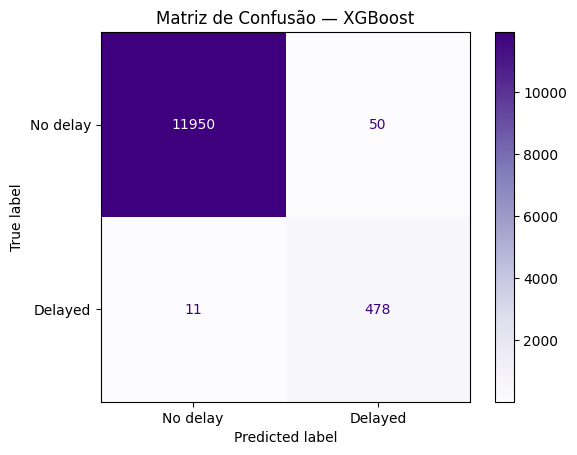

In [29]:
best_model = "XGBoost" if results.loc[1,"AUC"] > results.loc[0,"AUC"] else "Decision Tree"
print(f"🏆 Melhor modelo: {best_model}")

pred_best = pred_xgb if best_model == "XGBoost" else pred_tree
y_hat = (pred_best >= 0.5).astype(int)
cm = confusion_matrix(y_val, y_hat)
ConfusionMatrixDisplay(cm, display_labels=["No delay","Delayed"]).plot(cmap="Purples")
plt.title(f"Matriz de Confusão — {best_model}")
plt.show()


<div style="background: linear-gradient(90deg, #673AB7, #512DA8); padding: 14px; border-radius: 12px; color: white;">
  <h3>🏆 XGBoost Campeão do Duelo!</h3>
  <p>Com AUC de <b>0.9996</b> e Recall de <b>97.7%</b>, o modelo se destaca pela capacidade de identificar atrasos quase com perfeição.</p>
  <p style="font-size:14px;">💡 Ideal para uso em sistemas logísticos preditivos — antecipando riscos de atraso e otimizando operações.</p>
</div>

# 🔍 04 — Explicabilidade com SHAP (Shapley Additive Explanations)


Nesta seção, analisei as **principais variáveis** que levam o modelo XGBoost a prever um atraso de entrega.

Usei o **SHAP**, uma técnica de interpretabilidade baseada na Teoria dos Jogos, que mostra o quanto cada feature contribui para aumentar ou diminuir a probabilidade de atraso.

👉 O objetivo é entender **por que** o modelo faz suas previsões — e traduzir isso em **decisões de negócio**.

### 📦 Passo 1 — Reutilizando o Modelo XGBoost

Reutilizei o pipeline do modelo campeão (**XGBoost**) e aplicamos o SHAP sobre a base de validação (`X_val`), para entender como ele chegou às suas previsões.

> ⚙️ *O SHAP funciona como uma “lente de raio-X” sobre o modelo, permitindo ver o impacto individual de cada variável.*

In [35]:
print("📦 Carregando dataset GOLD e reusando modelo XGBoost...")

# Reutilizando o pipeline XGBoost já treinado
X_val_enc = xgb.named_steps["prep"].transform(X_val)
model = xgb.named_steps["model"]

# Caso o OneHotEncoder tenha retornado matriz esparsa, convertendo para denso
if not isinstance(X_val_enc, np.ndarray):
    print("💾 Convertendo matriz esparsa para formato denso...")
    X_val_enc = X_val_enc.toarray()

📦 Carregando dataset GOLD e reusando modelo XGBoost...
💾 Convertendo matriz esparsa para formato denso...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### ⚙️ Passo 2 — Geração dos Valores SHAP

O **SHAP explainer** calcula o impacto de cada feature no resultado do modelo.  
Valores positivos indicam **aumento da probabilidade de atraso**, enquanto negativos indicam **redução da chance de atraso**.

### 📈 Passo 3 — Impacto Global (SHAP Summary Plot)

O gráfico abaixo mostra o **impacto global das 15 variáveis mais relevantes**.  
Cada ponto representa um pedido individual:

- 🔴 Vermelho → valores altos da feature  
- 🔵 Azul → valores baixos  
- Eixo X → quanto cada variável empurra a previsão para “atraso” ou “pontualidade”

> 📊 *Quanto mais à direita, maior o impacto da feature em aumentar o risco de atraso.*


📈 Plotando SHAP Summary...


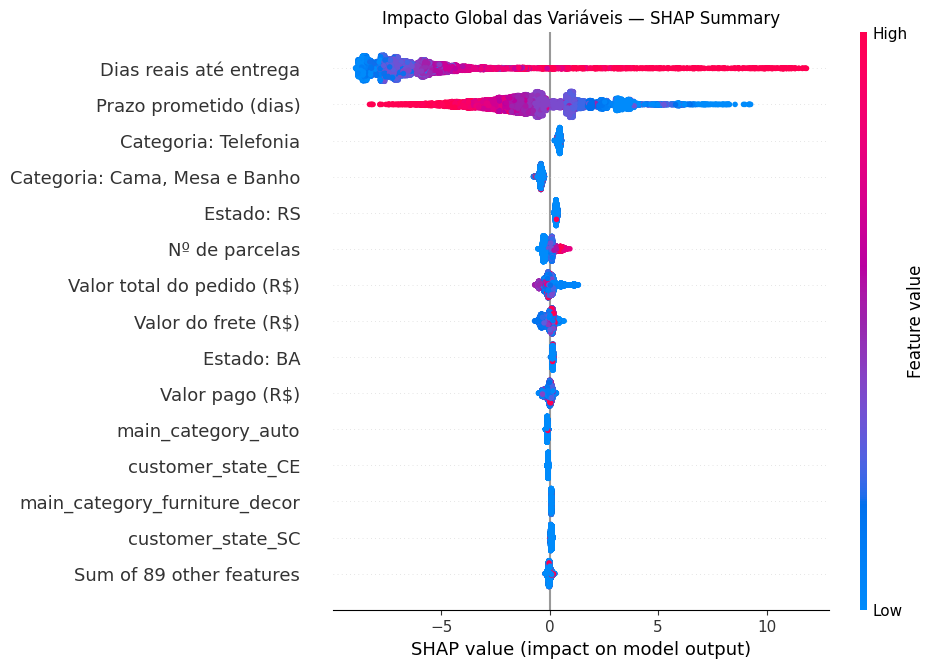

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [76]:
# 📈 Impacto Global das Variáveis
print("📈 Plotando SHAP Summary...")
plt.title("Impacto Global das Variáveis — SHAP Summary")
shap.plots.beeswarm(shap_values, max_display=15)
plt.show()


### 📊 Passo 4 — Importância Média das Features

O gráfico de barras mostra a **magnitude média** dos efeitos SHAP, ou seja, o quanto cada variável influencia as previsões em média.

> 🧩 *Serve para identificar as features mais relevantes para o modelo, independente do sinal positivo ou negativo.*

📊 Plotando importância média das features...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


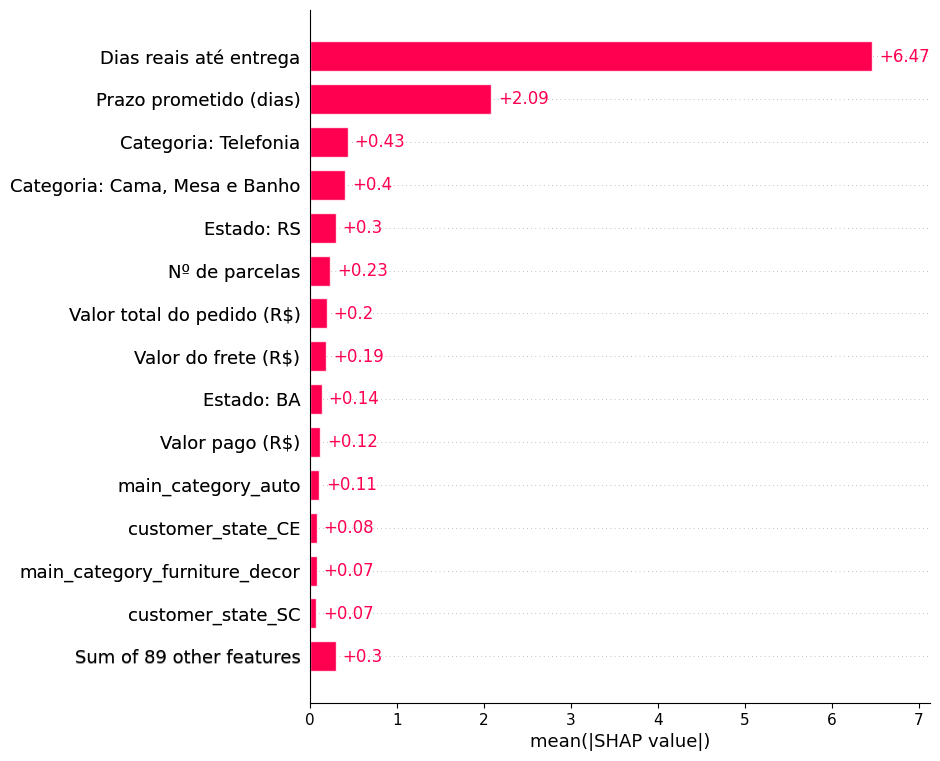

In [77]:
# 📊 Importância média (valores absolutos)
print("📊 Plotando importância média das features...")
shap.plots.bar(shap_values, max_display=15)
plt.show()

### 🎯 Passo 5 — Principais Features (Top 10 por Impacto SHAP)

Abaixo estão as dez variáveis com maior impacto no modelo.  
Essas são as **principais responsáveis** por determinar se um pedido será atrasado ou entregue no prazo.

In [78]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
top_idx = np.argsort(mean_abs_shap)[-10:][::-1]
top_features = [friendly_feature_names[i] for i in top_idx]

print("\n🎯 Principais features (por impacto SHAP — nomes legíveis):")
for i, f in enumerate(top_features, 1):
    print(f"{i}. {f}")


🎯 Principais features (por impacto SHAP — nomes legíveis):
1. Dias reais até entrega
2. Prazo prometido (dias)
3. Categoria: Telefonia
4. Categoria: Cama, Mesa e Banho
5. Estado: RS
6. Nº de parcelas
7. Valor total do pedido (R$)
8. Valor do frete (R$)
9. Estado: BA
10. Valor pago (R$)


### 📊 Passo 6 — Relação Detalhada (Feature `promised_days`)

Por fim, analisai a variável **`promised_days`**, que representa o prazo prometido de entrega.  
O gráfico de dependência mostra **como o aumento do prazo afeta a probabilidade de atraso**.

> ⏱️ *Prazos muito curtos elevam a chance de atraso — insight crítico para otimizar políticas de frete e logística.*


📊 Gerando gráfico de dependência para 'promised_days'...


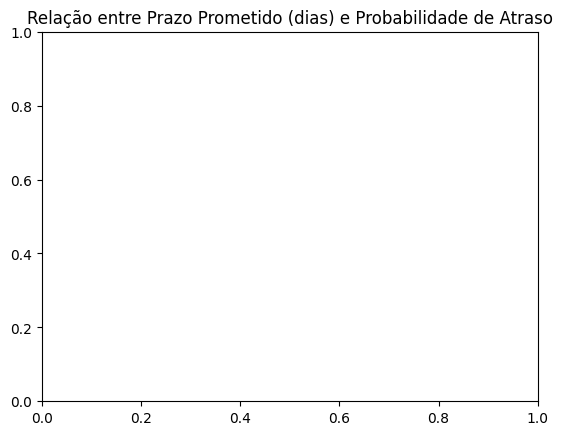

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


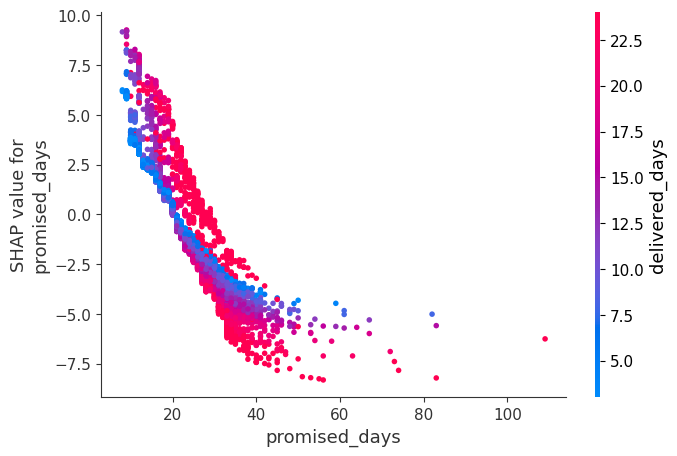

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [61]:
print("\n📊 Gerando gráfico de dependência para 'promised_days'...")
promised_idx = [i for i, name in enumerate(all_feature_names) if "promised_days" in name]

if promised_idx:
    idx = promised_idx[0]
    plt.title("Relação entre Prazo Prometido (dias) e Probabilidade de Atraso")
    shap.dependence_plot(
        idx,
        shap_values.values,
        X_val_enc,
        feature_names=all_feature_names,
        show=True
    )
else:
    print("⚠️ A coluna 'promised_days' não foi encontrada após o encoding.")


---

### 🔧 Exportando os dados para uso no dashboard no Google Looker Studio

Neste bloco, vou preparar os dados finais da camada GOLD para exportação, a fim de criar um dashboard no Looker Studio.  
Os passos desempenhados são:
1. Carregar o dataset GOLD previamente tratado (`features_is_late.parquet`).  
2. Limpar e normalizar os campos (remoção de caracteres especiais, ajuste em colunas de texto).  
3. Criar legendas e renomeações de colunas conforme padrão para visualização.  
4. Exportar para formato CSV compatível com o Looker Studio (`UTF-8`, separador vírgula).  
5. Baixar o arquivo e conectar ao Looker.

In [81]:
# Carrega o JSON salvo anteriormente
with open("feature_name_map.json", "r", encoding="utf-8") as f:
    name_map = json.load(f)

# Converte para DataFrame e exporta em UTF-8 compatível
df_map = pd.DataFrame(list(name_map.items()), columns=["coluna_original", "nome_legivel"])
df_map.to_csv("feature_name_map.csv", index=False, encoding="utf-8-sig")

print("✅ feature_name_map.csv exportado com sucesso (UTF-8 compatível com Looker Studio)")

✅ feature_name_map.csv exportado com sucesso (UTF-8 compatível com Looker Studio)


In [82]:
from google.colab import files
files.download("feature_name_map.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
# Recarrega o dataset GOLD diretamente do parquet
df = pd.read_parquet("data/gold/features_is_late.parquet")

# Converte tipos e remove caracteres problemáticos
for c in df.columns:
    if df[c].dtype == "object":
        df[c] = (
            df[c]
            .astype(str)
            .replace({r"[\r\n]": " ", r"[;]": ".", r"[,\t]": " "}, regex=True)
            .str.strip()
        )

# Remove colunas com caracteres invisíveis ou espaços
df.columns = [c.strip().replace("\ufeff", "").replace(" ", "_") for c in df.columns]

# Confirma estrutura
print(f"✅ {len(df)} linhas | {len(df.columns)} colunas")
print("📄 Colunas:", list(df.columns))

# Exporta com separador seguro e codificação universal
df.to_csv(
    "olist_gold_features_looker.csv",
    index=False,
    sep=",",
    encoding="utf-8",
    quotechar='"'
)
print("💾 Arquivo salvo: olist_gold_features_looker.csv")


✅ 98666 linhas | 16 colunas
📄 Colunas: ['order_id', 'order_purchase_timestamp', 'is_late', 'n_items', 'total_price', 'freight', 'pay_value', 'installments', 'is_credit_card', 'is_boleto', 'promised_days', 'delivered_days', 'dow', 'month', 'customer_state', 'main_category']


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


💾 Arquivo salvo: olist_gold_features_looker.csv


In [86]:
files.download("olist_gold_features_looker.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

> 📂 **Arquivo gerado:** `olist_gold_features_looker.csv`  
> ✅ Formatado para visualização e performance no dashboard.  
>

> [Link do relatório](https://lookerstudio.google.com/reporting/ef01fad6-5056-457a-b2cb-561cc0af28e2)  
